# Cahn-Hilliard Equation

This notebook will produce example data for the Cahn-Hilliard equation and then identify the underlying partial differential equation.

## Time simulation

The `tsme` package provides a number of pre-implemented dynamical systems, so we simply import the class `CahnHilliard`. (See this [page](https://nonlinear-physics.zivgitlabpages.uni-muenster.de/ag-kamps/tsme/source/tsme.premade_models.html) for more models.)

In [1]:
%%capture
%cd ..
import numpy as np
from tsme.premade_models import CahnHilliard
np.random.seed(239847)

The Cahn-Hilliard equation can be written as follows:
$$
\frac{\text{d}u}{\text{d}t} = \nabla^2 \left(u^3 - \alpha \, u - D \, \nabla^2 u \right)
$$

As we are dealing with a spatially extended 2D system we first set our spatial disctretization and domain sizes in $x$ and $y$ direction respectively.  Then we define a time interval as well as the time stamps at which we want to sample our trajectory. The initial condition is set to random noise between -0.25 and +0.25.

In [2]:
N = 128
Lx = 90
Ly = 90
domain = ((0, Lx), (0, Ly))

time = [0, 15]

u0 = (np.random.random((N, N)) - 0.5) * 0.5

We pass the initial condition and domain boundaries to our pre-defined Cahn-Hilliard model. The parameters $D$ and $\alpha$ in the above equation are both set to one. Now we perform the time simulation (this may take up to a few minutes depending on hardware and time frame).

In [3]:
che = CahnHilliard(ic=np.array([u0]), dom=domain, params=[1.0, 1.0])
sol = che.simulate([time[0], time[-1]], method="DOP853")

IVP: 100%|##########| 15.0/15.0 [23:05<00:00, 92.36s/ut]                     


Next we visualize the simulation using the (arguably primitive) animation function and matplotlib:

In [4]:
%%capture
from tsme.utils.visualization import animate
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.axis("off")
anima = animate(sol, time=time, fig=fig, ax=ax, go_by=2)
plt.close(fig)

In [5]:
from IPython import display
# display.HTML(anima.to_jshtml())
display.HTML(anima.to_html5_video())

## Infer differential equations

Now we import the model that will 'learn' the differential equations from `tsme`.

In [6]:
from tsme.model_estimation.model import Model

We need to pass the trajectory, domain size and the time stamps to our model. Then we can automatically generate a library of possible test functions for our right-hand side. Here we take the powers of $u$ up to third order and then all spatial derivatives up to fourth order of said powers (these include both spatial directions and their mixed derivatives).

In [7]:
estimated_model = Model(sol, che.time, phys_domain=domain)
estimated_model.init_library(3, 4)
estimated_model.print_library()

|   Index | Term                          |   Value 0 |
|---------|-------------------------------|-----------|
|       0 | 1.0                           |         0 |
|       1 | u[0]                          |         0 |
|       2 | u[0]*u[0]                     |         0 |
|       3 | u[0]*u[0]*u[0]                |         0 |
|       4 | d_dx(u[0],1)                  |         0 |
|       5 | d_dy(u[0],1)                  |         0 |
|       6 | d_dx(u[0]*u[0],1)             |         0 |
|       7 | d_dy(u[0]*u[0],1)             |         0 |
|       8 | d_dx(u[0]*u[0]*u[0],1)        |         0 |
|       9 | d_dy(u[0]*u[0]*u[0],1)        |         0 |
|      10 | d_dx(u[0],2)                  |         0 |
|      11 | d_dy(u[0],2)                  |         0 |
|      12 | dd_dxdy(u[0],(1,1))           |         0 |
|      13 | d_dx(u[0]*u[0],2)             |         0 |
|      14 | d_dy(u[0]*u[0],2)             |         0 |
|      15 | dd_dxdy(u[0]*u[0],(1,1))      |     

Of course just after initialization the linear factors of all these library terms are yet to be determined. We tell our model to construct a simulator with the above library that can facilitate time simulations. (The library supports some basic manipulations at this point, but more on that in a future tutorial). Now we can call the optimization routine to find the best combination of our trial functions. (For more detail see [here](https://nonlinear-physics.zivgitlabpages.uni-muenster.de/ag-kamps/tsme/source/tsme.html#tsme.model_estimation.model.Model.optimize_sigma))

In [8]:
estimated_model.optimize_sigma(max_evals=10)
sigma_BIC = estimated_model.sigma

Generating library functions (this may take some time)...
100%|██████████| 10/10 [17:05<00:00, 102.57s/trial, best loss: 7613.9592292816205]
Optimal threshold(s) found: {'t0': 0.8189787983433431}
New Sigma set to: 

|   Index | Term                   |   Value 0 |
|---------|------------------------|-----------|
|      10 | d_dx(u[0],2)           | -0.987891 |
|      11 | d_dy(u[0],2)           | -0.989839 |
|      16 | d_dx(u[0]*u[0]*u[0],2) |  0.984235 |
|      17 | d_dy(u[0]*u[0]*u[0],2) |  0.981134 |
|      31 | d_dx(u[0],4)           | -1.01885  |
|      32 | d_dy(u[0],4)           | -1.01882  |
|      35 | dd_dxdy(u[0],(2,2))    | -1.90139  |


In [9]:
estimated_model.optimize_sigma(lamb=0.01, thres=0.1, error="SINDy", backend="train")
sigma_SINDy = estimated_model.sigma

Training sequencing threshold ridge regression with SINDy  error: 100%|██████████| 10/10 [11:47<00:00, 70.79s/it, Threshold=0.1, Error=391]

New Sigma set to: 

|   Index | Term                          |      Value 0 |
|---------|-------------------------------|--------------|
|       0 | 1.0                           |  2.50829e-05 |
|       1 | u[0]                          |  0.0181964   |
|       2 | u[0]*u[0]                     | -0.00206161  |
|       3 | u[0]*u[0]*u[0]                |  0.236254    |
|       4 | d_dx(u[0],1)                  | -0.000511677 |
|       5 | d_dy(u[0],1)                  | -0.00181625  |
|       6 | d_dx(u[0]*u[0],1)             |  0.00565388  |
|       7 | d_dy(u[0]*u[0],1)             |  0.00519014  |
|       8 | d_dx(u[0]*u[0]*u[0],1)        | -0.00145271  |
|       9 | d_dy(u[0]*u[0]*u[0],1)        |  0.00518876  |
|      10 | d_dx(u[0],2)                  | -0.942456    |
|      11 | d_dy(u[0],2)                  | -0.956784    |
|      12 | dd_dxdy(u[0],(1,1))           | -0.0195113   |
|      13 | d_dx(u[0]*u[0],2)             | -0.00383587  |
|      14 | d_dy(u[0]*u[0],2)       

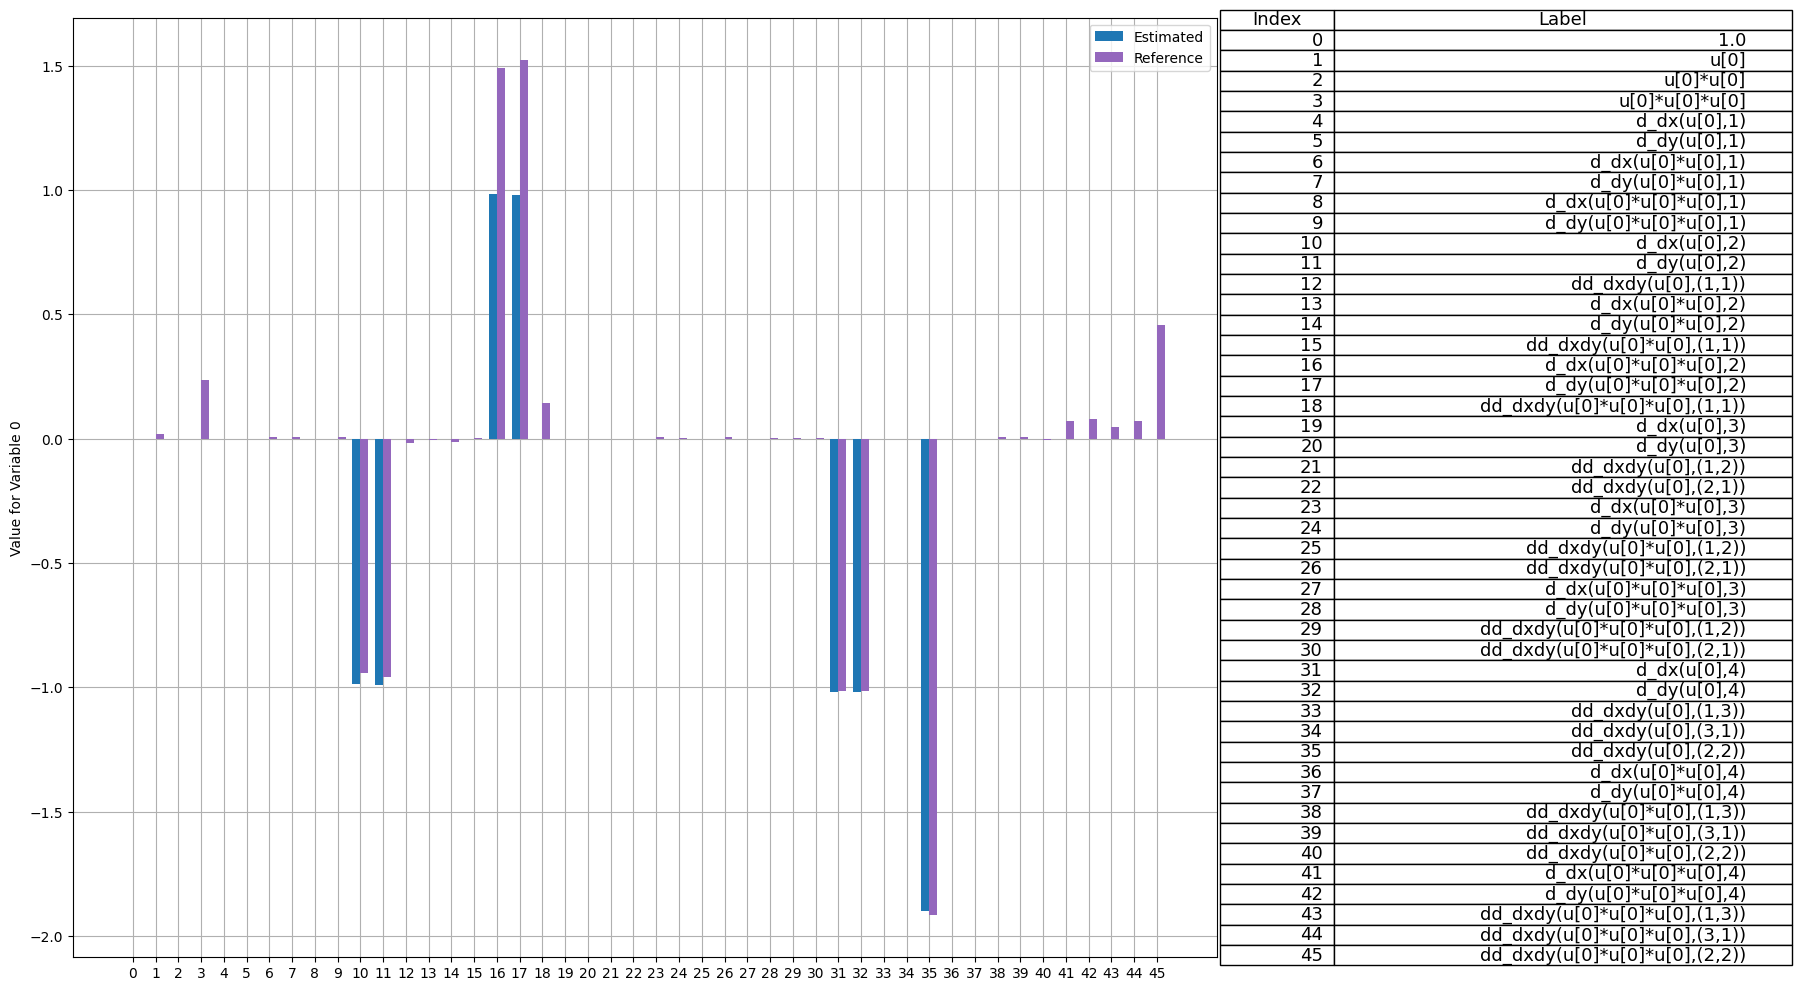

In [10]:
from tsme.utils.visualization import barplot_parameters

labels = estimated_model.print_strings
barplot_parameters(sigma_BIC, sigma_ref=sigma_SINDy, labels=labels, figsize=(18, 10), table_fontsize=13)